In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import multivariate_normal
import tensorflow as tf
import tensorflow.contrib.slim as slim
import os
import keras

Using TensorFlow backend.


In [13]:
os.environ["CUDA_VISIBLE_DEVICES"] = ''

In [21]:
np.set_printoptions(precision=3, linewidth=200, suppress=True)

In [3]:
mnist_data = keras.datasets.mnist.load_data()

In [4]:
len(mnist_data),len(mnist_data[0])

(2, 2)

In [5]:
mnist_data[0][0].shape, mnist_data[0][1].shape,
mnist_data[1][0].shape, mnist_data[1][1].shape

((10000, 28, 28), (10000,))

In [6]:
x_train = mnist_data[0][0]
y_train = mnist_data[0][1]
x_test = mnist_data[1][0]
y_test = mnist_data[1][1]
x_train.shape, y_train.shape, x_test.shape, y_test.shape, np.max(x_train), np.max(y_train)

((60000, 28, 28), (60000,), (10000, 28, 28), (10000,), 255, 9)

Text(0.5, 1.0, '5')

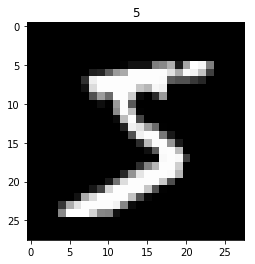

In [7]:
plt.imshow(x_train[0], cmap='gray')
plt.title(y_train[0])

In [215]:
import module

In [291]:
def transformation(x):
    basic_shape = tf.shape(x[:,0,0,0])
    
    s = 0.2
    t = a = 0.4
    sx = tf.random_uniform(basic_shape,1-s, 1+s)
    ax = tf.random_uniform(basic_shape,-a, a)
    tx = tf.random_uniform(basic_shape,-a, a)
    sy = tf.random_uniform(basic_shape,1-s, 1+s)
    ay = tf.random_uniform(basic_shape,-a, a)
    ty = tf.random_uniform(basic_shape,-a, a)
    ones = tf.ones_like(sx)
    zeros = tf.zeros_like(sx)
    #transforms = [sx, ax, tx, ay, sy, ty, 0, 0]
    #transforms = [sx, 0, -tx, 0, 1, -ty, 0, 0] 
    #coef = tf.stack((sx, ax,tx, ay, sy, ty, ones, ones), -1)
    transforms = tf.stack((sx, ax, tx, ay, sy, ty, zeros, zeros), -1)
    return tf.contrib.image.transform(x, transforms)#, interpolation='BILINEAR')

In [292]:
def rotate(x, max_angle):
    max_angle = tf.cast(max_angle, tf.float32)
    degree = tf.random_uniform(tf.shape(x[:,0,0,0]),-max_angle, max_angle)
    #degree = max_angle
    radian = degree * np.pi / 180
    return tf.contrib.image.rotate(x, radian, interpolation='BILINEAR') #NEAREST, BILINEAR

In [301]:
def inference(x):
    net = slim.conv2d(x, 32, kernel_size=[7,7], stride=2)
    net = slim.conv2d(net, 64, kernel_size=[3,3], stride=2)
    theta = slim.conv2d(net, 6, kernel_size=[3,3])
    
    return net, theta[:, 3, 3]

In [305]:
is_scratch = False
pkt = 'check.pkt'

In [306]:
learning_rate = 0.5
tf.reset_default_graph()
X = tf.placeholder(tf.uint8, [None, 28, 28])
x_4d = tf.expand_dims(X, -1)
x = tf.cast(x_4d, tf.float32)/255.0

if is_scratch:    
    x_rotate = rotate(x, 10)
else:
    x_rotate = rotate(x, 45)
    x_rotate = transformation(x)
    
net, theta = inference(x_rotate)
theta = tf.reshape(theta, [-1, 2, 3])
theta_initial = tf.reshape([1,0,0,0,1,0.0], [-1, 2, 3])

if is_scratch:    
    cost = tf.reduce_mean(tf.square(theta - theta_initial))    
    m = tf.shape(x)[0]
    theta = tf.tile(theta_initial, [m,1,1])
    
out = module.spatial_transformer_network(x_rotate, theta)

if not is_scratch:
    cost = tf.reduce_mean(tf.square(x - out))
    
train = tf.train.GradientDescentOptimizer(learning_rate).minimize(cost)
saver = tf.train.Saver()
sess = tf.InteractiveSession()
if is_scratch:
    sess.run(tf.global_variables_initializer())
else:
    saver.restore(sess, pkt)

INFO:tensorflow:Restoring parameters from check.pkt


0 0.092631176
100 0.086843684
200 0.08738447
300 0.09569802
400 0.0844318
500 0.088995226
600 0.08348555
700 0.086296774
800 0.085979946
900 0.08491499


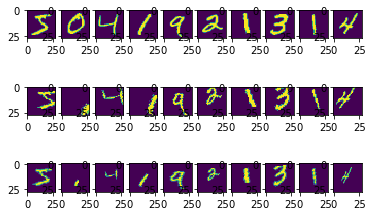

In [308]:
np.set_printoptions(precision=3, linewidth=200, suppress=True)

data_m = 100
epoch = 1000
for i in range(epoch):
    _, _cost, out_sample = sess.run([train, cost, out], {X:x_train[:data_m], )
    if i%(epoch//10)==0:
        print(i, _cost)
        
saver.save(sess, pkt)

_x, _x_rot, _out = sess.run([x, x_rotate, out], {X:x_train[:data_m]})
display_img = np.stack((_x, _x_rot, _out), axis=0)
display_img = np.squeeze(display_img, -1)
display_img = (display_img*255).astype(np.uint8)

display_m = min(data_m, 10)
fig, ax=plt.subplots(3, display_m)
for i in range(display_m):    
    ax[0, i].imshow(display_img[0, i])
    ax[1, i].imshow(display_img[1, i])
    ax[2, i].imshow(display_img[2, i])

0 0.08293901
500 0.06424119
1000 0.048063252
1500 0.0593247
2000 0.07429648
2500 0.06738982
3000 0.061619136
3500 0.0520826
4000 0.077277474
4500 0.063593894


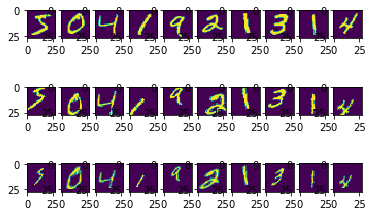

In [300]:
np.set_printoptions(precision=3, linewidth=200, suppress=True)

data_m = 10
epoch = 5000
for i in range(epoch):
    _, _cost, out_sample = sess.run([train, cost, out], {X:x_train[:data_m]})
    if i%(epoch//10)==0:
        print(i, _cost)
        
saver.save(sess, pkt)

_x, _x_rot, _out = sess.run([x, x_rotate, out], {X:x_train[:data_m]})
display_img = np.stack((_x, _x_rot, _out), axis=0)
display_img = np.squeeze(display_img, -1)
display_img = (display_img*255).astype(np.uint8)

fig, ax=plt.subplots(3, data_m)
for i in range(data_m):    
    ax[0, i].imshow(display_img[0, i])
    ax[1, i].imshow(display_img[1, i])
    ax[2, i].imshow(display_img[2, i])